In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('./data/train.csv')


book_ids = df['book_id'].unique()
user_ids = df['user_id'].unique()

nb_books = len(book_ids)
nb_users = len(user_ids)
#unique index for each user and book in the matrix
book_idx = {ids: i for i,ids in enumerate(book_ids)}
user_idx = {ids: i for i,ids in enumerate(user_ids)}

df_train, df_val = train_test_split(df, test_size=0.25, random_state= 42)

In [3]:
X_train = np.zeros((nb_users, nb_books))

#inspired from code in week 5 exercise
for line in df_train.itertuples():
    X_train[user_idx[line[2]], book_idx[line[1]]] = line[3]

#for validation during hyperparameter search
X_val = np.zeros((nb_users, nb_books))

for line in df_val.itertuples():
    X_val[user_idx[line[2]], book_idx[line[1]]] = line[3]


#to only get defined indexes for SGD (faster search of a random index)
nz_row, nz_col = X_train.nonzero()
nz_entries = list(zip(nz_row, nz_col))



In [4]:

#only on nonzero indexes
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten()
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()

    return np.sqrt(mean_squared_error(prediction, ground_truth))


In [5]:

def SGD(X, nz_entries, nb_epoch, epoch_size, P, Q, lr, lambda_, X_val, compute_error):

    iter = 0
    loss = []
    plot_idx = []
    MAX_ITER = nb_epoch*epoch_size
    count_epoch = 0

    d = np.shape(P)[1]
    nb_nz = len(nz_entries)


    while iter < MAX_ITER:

        rand_entry = np.random.choice(nb_nz)
        i_rand, j_rand = nz_entries[rand_entry]
        r = X[i_rand, j_rand]

        
        error = r - np.dot(P[i_rand, :], Q[j_rand, :])

        if iter % epoch_size == 0:
            if compute_error:
                R_hat = np.dot(P, Q.T)
                R_hat = np.clip(R_hat, 0, 5)
                val_error = rmse(R_hat, X_val)
                loss.append(val_error)
                plot_idx.append(count_epoch)
            print(f'done with {count_epoch} epochs')
            count_epoch +=1

        for update_idx in range(d):
            pik = P[i_rand, update_idx]
            qkj = Q[j_rand, update_idx]
            P[i_rand, update_idx] += 2*lr*(error*qkj - lambda_*pik)
            Q[j_rand, update_idx] += 2*lr*(error*pik - lambda_*qkj)

        iter +=1


    return P, Q, plot_idx, loss

In [6]:
def grid_search(d_val, lambda_val, X_train, X_val, nz_entries, lr, nb_epoch, epoch_size):

    var = 0.01
    MSE_map = np.zeros((len(d_val), len(lambda_val)))

    for i, d in enumerate(d_val):
        P = var*np.random.randn(nb_users, d)
        Q = var*np.random.randn(nb_books, d)
        for j, lambda_ in enumerate(lambda_val):
            P_hat, Q_hat, _, _ = SGD(X_train, nz_entries, nb_epoch, epoch_size, np.copy(P), np.copy(Q), lr, lambda_, X_val, False)

            R_hat = np.dot(P_hat, Q_hat.T)
            R_hat = np.clip(R_hat, 0, 5)

            MSE_map[i,j] = rmse(R_hat, X_val) 
            print(f'done with ({d, lambda_}')

    return MSE_map
    

In [26]:
ds = [50]
lambdas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
lr = 0.01
nb_epoch = 10


MSE_map = grid_search(ds, lambdas, X_train, X_val, nz_entries, lr, nb_epoch, len(df_train))
np.savetxt('MSE_map.txt', MSE_map)

done with 0 epochs
done with 1 epochs
done with 2 epochs
done with 3 epochs
done with 4 epochs
done with 5 epochs
done with 6 epochs
done with 7 epochs
done with 8 epochs
done with 9 epochs
done with ((50, 0.0001)
done with 0 epochs
done with 1 epochs
done with 2 epochs
done with 3 epochs
done with 4 epochs
done with 5 epochs
done with 6 epochs
done with 7 epochs
done with 8 epochs
done with 9 epochs
done with ((50, 0.001)
done with 0 epochs
done with 1 epochs
done with 2 epochs
done with 3 epochs
done with 4 epochs
done with 5 epochs
done with 6 epochs
done with 7 epochs
done with 8 epochs
done with 9 epochs
done with ((50, 0.01)
done with 0 epochs
done with 1 epochs
done with 2 epochs
done with 3 epochs
done with 4 epochs
done with 5 epochs
done with 6 epochs
done with 7 epochs
done with 8 epochs
done with 9 epochs
done with ((50, 0.1)
done with 0 epochs
done with 1 epochs
done with 2 epochs
done with 3 epochs
done with 4 epochs
done with 5 epochs
done with 6 epochs
done with 7 epoch

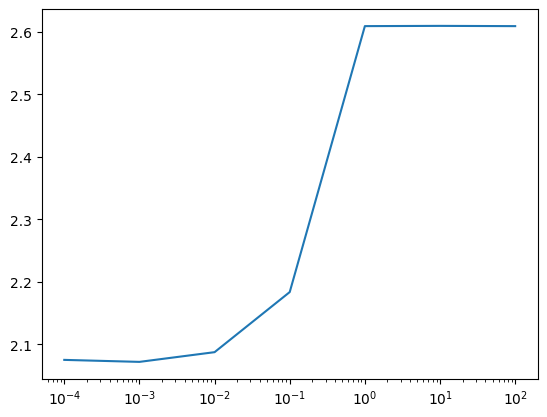

In [29]:
plt.plot(lambdas, MSE_map[0,:])
plt.xscale('log')

In [ ]:
MSE_map = np.loadtxt('./MSE_map.txt')
sns.heatmap(MSE_map, cmap='viridis', fmt='.3f', xticklabels=lambdas, yticklabels=ds, annot=True, cbar=True)
plt.title(r'Grid search for optimal $d$ and $\lambda$' + f' on {nb_epoch} epochs')
plt.xlabel(r'$\lambda$')
plt.ylabel(r'$d$')
plt.savefig('./plot/gridseach.pdf')

In [7]:
#we train on the whole dataset for the best param
X_final = np.zeros((nb_users, nb_books))

for line in df.itertuples():
    X_final[user_idx[line[2]], book_idx[line[1]]] = line[3]


nz_row, nz_col = X_final.nonzero()
nz_entries_final = list(zip(nz_row, nz_col))





done with 0 epochs
done with 1 epochs
done with 2 epochs
done with 3 epochs
done with 4 epochs
done with 5 epochs
done with 6 epochs
done with 7 epochs
done with 8 epochs
done with 9 epochs
done with 10 epochs
done with 11 epochs
done with 12 epochs
done with 13 epochs
done with 14 epochs
done with 15 epochs
done with 16 epochs
done with 17 epochs
done with 18 epochs
done with 19 epochs
done with 20 epochs
done with 21 epochs
done with 22 epochs
done with 23 epochs
done with 24 epochs
done with 25 epochs
done with 26 epochs
done with 27 epochs
done with 28 epochs
done with 29 epochs
done with 30 epochs
done with 31 epochs
done with 32 epochs
done with 33 epochs
done with 34 epochs
done with 35 epochs
done with 36 epochs
done with 37 epochs
done with 38 epochs
done with 39 epochs
done with 40 epochs
done with 41 epochs
done with 42 epochs
done with 43 epochs
done with 44 epochs
done with 45 epochs
done with 46 epochs
done with 47 epochs
done with 48 epochs
done with 49 epochs


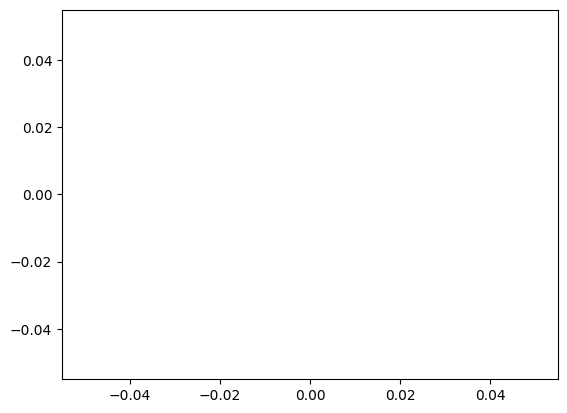

In [ ]:
lambda_star = 0.02
d_star = 100
nb_epoch = 50
lr = 1e-3
var = 0.01

P = var*np.random.randn(nb_users, d_star)
Q = var*np.random.randn(nb_books, d_star)

P_hat, Q_hat, loss_idx, loss = SGD(X_train, nz_entries, nb_epoch, len(nz_entries), P, Q, lr, lambda_star, X_val, False)

#plt.plot(loss_idx, loss)

In [9]:

R_hat = np.dot(P_hat, Q_hat.T)
R_hat = np.clip(R_hat, 0, 5)
rmse(R_hat, X_final)


2.5019680686789383

In [ ]:
#takes too long and useless
def threshold(R_hat):

    R_thresholded = np.copy(R_hat)
    values = np.array([0 + 0.5*i for i in range(11)])

    m,n = R_hat.shape
    for i in range(m):
        for j in range(n):
            old_val = R_hat[i,j]
            thresh_idx = np.argmin(np.abs(values - old_val))
            R_thresholded[i,j] = values[thresh_idx]

    return R_thresholded

R_thresholded = threshold(R_hat)
rmse(R_thresholded, X_final)

In [ ]:
def thresh_submission(predictions):
    values = np.array([0 + 0.5*i for i in range(11)])
    new_pred = [0]*len(predictions)

    for i,pred in enumerate(predictions):
        thresh_idx = np.argmin(np.abs(values - pred))
        new_pred[i] = values[thresh_idx]

    return new_pred
    

In [22]:

def write_submission(R_hat, user_idx, book_idx, thresh):

    df_test = pd.read_csv('./data/test.csv')
    test_book = df_test['book_id'].values
    test_user = df_test['user_id'].values
    nb_test = len(df_test)
    predictions = [0]*nb_test
    for i in range(nb_test):
        predictions[i] = R_hat[user_idx[test_user[i]], book_idx[test_book[i]]]

    if thresh:
        predictions = thresh_submission(predictions)

    submission = pd.DataFrame({
        'id':range(len(df_test)),
        'rating': predictions
    })

    submission.to_csv('./submission.csv', index=False)
    return submission


submission = write_submission(R_hat, user_idx, book_idx, False)

submission

,id,rating
0,0,2.379253
1,1,2.030979
2,2,0.848260
3,3,1.100827
4,4,2.181549
...,...,...
29362,29362,1.223162
29363,29363,1.422624
29364,29364,2.401210
29365,29365,2.405121
